In [25]:
import numpy as np 
import pandas as pd
import mne 
import os
import plotly.graph_objects as go 
import multiprocessing
import synchro_code as sc #NOTE: this is a folder that store my code. It is not a common library. 

from tqdm import tqdm
from bids import BIDSLayout
from bids.tests import get_test_data_path
from joblib import Parallel, delayed

# Extract the data

In [2]:
# @title Extract the data
#extract the data for [difference group of participants]
participants_file = '/home/hengjie/Desktop/alzheimer_openneuro/participants.tsv'

participants_df = pd.read_csv(participants_file, delimiter='\t')

#alzheimer group
alz_part = participants_df[participants_df['Group'] == 'A']
alz_id = alz_part['participant_id'].tolist()
alz_id = [s.replace('sub-', '') for s in alz_id]

#frontotemporal dementia group
dem_part = participants_df[participants_df['Group'] == 'F']
dem_id = dem_part['participant_id'].tolist()
dem_id = [s.replace('sub-', '') for s in dem_id]

#healthy group
con_part = participants_df[participants_df['Group'] == 'C']
con_id = con_part['participant_id'].tolist()
con_id = [s.replace('sub-', '') for s in con_id]

#particiapants data
print(participants_df)

   participant_id Gender  Age Group  MMSE
0         sub-001      F   57     A    16
1         sub-002      F   78     A    22
2         sub-003      M   70     A    14
3         sub-004      F   67     A    20
4         sub-005      M   70     A    22
..            ...    ...  ...   ...   ...
83        sub-084      F   71     F    24
84        sub-085      M   64     F    26
85        sub-086      M   49     F    26
86        sub-087      M   73     F    24
87        sub-088      M   55     F    24

[88 rows x 5 columns]


In [3]:
# @title Read the BIDS format dataset
#read the BIDS format dataset
#NOTE: the [derivatives] should use the [derivatives] way of reading it but it does not work in this case. Hence, the author copy the [metadata] to the [derivatives].
data_path = os.path.join(get_test_data_path(), '/home/hengjie/Desktop/alzheimer_openneuro/derivatives')
layout = BIDSLayout(data_path)

In [4]:
alz_eeg_file = layout.get(subject=alz_id, return_type='filename', extension='.set')
dem_eeg_file = layout.get(subject=dem_id, return_type='filename', extension='.set')
con_eeg_file = layout.get(subject=con_id, return_type='filename', extension='.set')

In [126]:
#testing for [global field synchronization]
temp_data = mne.io.read_raw_eeglab(con_eeg_file[0], preload=True) #read the data
temp_data_all = temp_data.get_data()
temp_data_time = temp_data.times
global_func_connect_data = sc.global_func_connect(data=temp_data_all, int_freq=5, time=temp_data_time)
global_field_sync_data = sc.global_field_sync(global_func_connect_data)
print(f'global field synchronization: {global_field_sync_data}')

global field synchronization: 0.1433404970162773


In [127]:
temp_data.info['sfreq']

500.0

In [41]:
#testing for [cross synchronization divergence]
temp_data = mne.io.read_raw_eeglab(con_eeg_file[0], preload=True) #read the data
temp_data_all = temp_data.get_data()
temp_data_time = temp_data.times
phase_data = sc.phase_lock_seq(data=temp_data_all)
cross_synch_chnl_data = sc.cross_synch(data=phase_data[0,1])
cross_synch_data = sc.cross_synch_sys(data=phase_data)
print(f'cross synchronization divergence channel: {cross_synch_chnl_data}')
print(f'cross synchronization divergence: {cross_synch_data}')

100%|███████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  6.58it/s]


check PMF of data: 	 1.0
mean of data: 	 0.9475129172564665
std of data: 	 0.18175940203522636
check PMF of normal: 	 1.0000000000000004
check normal PMF mean: 	 0.9999643200000002
check normal PMF std: 	 0.10011792730044716
bin size of PMF: 500


100%|███████████████████████████████████████████████████████████████| 388550/388550 [00:01<00:00, 253044.37it/s]


check PMF of data: 	 1.0000000000000002
mean of data: 	 0.8698549284376386
std of data: 	 0.3107344664841139
check PMF of normal: 	 1.0000000000000002
check normal PMF mean: 	 1.0000232800000002
check normal PMF std: 	 0.09989384174232976
bin size of PMF: 500
cross synchronization divergence channel: 0.6834917339220964
cross synchronization divergence: 0.6382655977702032


# Global field synchronization

In [128]:
int_eeg_file = alz_eeg_file + con_eeg_file + dem_eeg_file

freqrange = (0.5, 5) #define the frequency range
step_freq = 0.5 #interval within the frequency range

participant_id_data = []
gfs_mean_data = []
gfs_std_data = []

for f in tqdm(int_eeg_file, position=0):
    temp_data = mne.io.read_raw_eeglab(f, preload=True) #read the data
    split_parts = f.split('/')
    temp_participant_id = split_parts[-3]
    
    int_freqrange = np.arange(*freqrange, step_freq)

    def process_data(temp_data, freq, time):
        temp_global_data = sc.global_func_connect(temp_data, freq, time)
        return sc.global_field_sync(temp_global_data)

    data_all = temp_data.get_data()
    data_time = temp_data.times
    gfs_range = Parallel(n_jobs=30)(
        delayed(process_data)(data_all, int_freqrange[i], data_time) for i in tqdm(range(len(int_freqrange)), position=0)
    )
    
    participant_id_data.append(temp_participant_id)
    gfs_mean_data.append(np.mean(gfs_range))
    gfs_std_data.append(np.std(gfs_range))
    
temp_save_data = np.vstack((participant_id_data, gfs_mean_data, gfs_std_data))
temp_save_data = temp_save_data.T

df_gfs = pd.DataFrame(temp_save_data, columns=['participant_id', 'gfs_mean', 'gfs_std'])

save_folder = '/media/hengjie/4TB/synchronization'
df_gfs.to_csv(f'{save_folder}/gfs_freq{np.min(int_freqrange)}-{np.max(int_freqrange)}_step{step_freq}.tsv', sep='\t', index=False)

  9%|██████▌                                                                  | 90/1000 [00:12<02:15,  6.72it/s]/home/hengjie/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

  2%|█▋                                                                       | 2/88 [05:57<4:05:06, 171.01s/it]/tmp/ipykernel_2820675/1118315950.py:11: RuntimeWarning:

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.

  3%|██▍                                                                      | 3/88 [08:04<3:34:06, 151.13s/it]/tmp/ipykernel_2820675/1118315950.py:11: RuntimeWarning:

The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.

  6%|████▏                                 

# Cross Synchronization Divergence, in for-loop

In [ ]:
int_eeg_file = alz_eeg_file + con_eeg_file + dem_eeg_file
fmin, fmax = 32, 100
chk_mean, chk_std = 1, 0.1
pdf_range = 1.5
pdf_bins = 'sturges'
int_method = 'wass'

participant_id_data = []
cross_data = []

for f in tqdm(int_eeg_file, position=0): 
    temp_data = mne.io.read_raw_eeglab(f, preload=True) #read the data
    temp_elec = temp_data.ch_names #electrode 
    temp_data = temp_data.pick(temp_elec)
    print(len(temp_data.ch_names))
    temp_data = temp_data.filter(fmin, fmax) #filter the signals to specific frequency band
    split_parts = f.split('/')
    temp_participant_id = split_parts[-3]
    temp_data_all = temp_data.get_data() #get all the data in array format. 
    
    temp_phase_lock_seq = sc.phase_lock_seq(temp_data_all)
    temp_cross_synch_sys = sc.cross_synch_sys(temp_phase_lock_seq, exp_range=pdf_range, bins=pdf_bins, check_mean=chk_mean, check_std=chk_std, check_pdf_info=True, method=int_method)
    print(f'cross synchorny: {temp_cross_synch_sys}')
    
    participant_id_data.append(temp_participant_id)
    cross_data.append(temp_cross_synch_sys)
    name_elec = ''.join(temp_elec)
    
temp_save_data = np.vstack((participant_id_data, cross_data))
temp_save_data = temp_save_data.T

df_gfs = pd.DataFrame(temp_save_data, columns=['participant_id', 'cross_synch'])

save_folder = '/media/hengjie/4TB/synchronization'
df_gfs.to_csv(f'{save_folder}/cross_synch_freq{fmin}-{fmax}_mean{chk_mean}_std{chk_std}_range{pdf_range}_bins{pdf_bins}_{int_method}_{name_elec}.tsv', sep='\t', index=False)

# Cross Synchronization Divergence; in parallalization calculation

In [240]:
from joblib import Parallel, delayed
import multiprocessing

int_eeg_file = alz_eeg_file + con_eeg_file + dem_eeg_file
fmin, fmax = 6.5, 8
chk_mean, chk_std = 1, 0.1
pdf_range = 1.5
pdf_bins = 30
int_method = 'wass'

# Define a function for processing each EEG file
def process_eeg_file(f, fmin, fmax, chk_mean, chk_std, pdf_bins, int_method):
    temp_data = mne.io.read_raw_eeglab(f, preload=True)
    temp_elec = temp_data.ch_names
    temp_data = temp_data.pick(temp_elec)
    temp_data = temp_data.filter(fmin, fmax)
    split_parts = f.split('/')
    temp_participant_id = split_parts[-3]
    temp_data_all = temp_data.get_data()
    
    temp_phase_lock_seq = sc.phase_lock_seq(temp_data_all)
    temp_cross_synch_sys = sc.cross_synch_sys(temp_phase_lock_seq, exp_range=pdf_range, bins=pdf_bins, check_mean=chk_mean, check_std=chk_std, check_pdf_info=True, method=int_method)
    
    return temp_participant_id, temp_cross_synch_sys, temp_elec

# Number of CPU cores to use
num_cores = multiprocessing.cpu_count()

participant_id_data = []
cross_data = []

# Parallelize the processing of EEG files
results = Parallel(n_jobs=int(num_cores/3))(
    delayed(process_eeg_file)(f, fmin, fmax, chk_mean, chk_std, pdf_bins, int_method) for f in tqdm(int_eeg_file, position=0)
)

# Extract results
for temp_participant_id, temp_cross_synch_sys, temp_elec in results:
    participant_id_data.append(temp_participant_id)
    cross_data.append(temp_cross_synch_sys)
    name_elec = ''.join(temp_elec)

# Rest of the code remains the same
temp_save_data = np.vstack((participant_id_data, cross_data))
temp_save_data = temp_save_data.T

df_gfs = pd.DataFrame(temp_save_data, columns=['participant_id', 'cross_synch'])

save_folder = '/media/hengjie/4TB/synchronization'
df_gfs.to_csv(f'{save_folder}/cross_synch_freq{fmin}-{fmax}_mean{chk_mean}_std{chk_std}_range{pdf_range}_bins{pdf_bins}_{int_method}_{name_elec}.tsv', sep='\t', index=False)


 15%|███████████                                                                | 13/88 [00:00<00:04, 16.38it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remainin

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of  

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Do

check PMF of data: 	 1.000000000000002
mean of data: 	 0.4339003803748744
std of data: 	 0.6405823295625729
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000220000000015
check normal PMF std: 	 0.10420652338505489
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



100%|██████████| 419050/419050 [00:02<00:00, 188513.68it/s]
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
 15%|█▌        | 66849/441760 [00:00<00:01, 224893.68it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 94%|█████████▍| 331484/353050 [00:01<00:00, 167054.56it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7428275038745954
std of data: 	 0.4276601411635791
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9993290000000016
check normal PMF std: 	 0.10408722188145861
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 16%|█▌        | 3/19 [00:00<00:04,  3.34it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000027
mean of data: 	 0.7225012314046229
std of data: 	 0.4480412929824301
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001440000000017
check normal PMF std: 	 0.10398355285332385
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



100%|██████████| 441760/441760 [00:01<00:00, 227980.56it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 57%|█████▋    | 219711/384960 [00:01<00:01, 155361.45it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 61%|██████    | 235260/384960 [00:01<00:00, 154738.93it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5928295769350485
std of data: 	 0.5562473882967459
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001550000000015
check normal PMF std: 	 0.10421600632820274
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 58%|█████▊    | 11/19 [00:03<00:02,  3.10it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]:

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.49303285722396806
std of data: 	 0.6362666891052129
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9996160000000015
check normal PMF std: 	 0.10398294352440689
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7473174032789585
std of data: 	 0.42580044511486653
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.00

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 63%|██████▎   | 12/19 [00:03<00:02,  3.08it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
  0%|          | 0/19 [00:00<?, ?it/s]3.04it/s]

check PMF of data: 	 1.0000000000000027
mean of data: 	 0.6852120969807114
std of data: 	 0.4764140854711566
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0003380000000017
check normal PMF std: 	 0.1040206025554553
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 79%|███████▉  | 15/19 [00:04<00:01,  3.01it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 84%|████████▍ | 16/19 [00:05<00:00,  3.05it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
  5%|▌         | 1/19 [00:00<00:04,  3.86it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 ou

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5935291225751224
std of data: 	 0.5522077132250967
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9998830000000015
check normal PMF std: 	 0.10428416136211668
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 26%|██▋       | 5/19 [00:01<00:03,  4.26it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6246422621127247
std of data: 	 0.5375176640452595
check PMF of normal: 	 1.0000000000000013
check normal PMF mean: 	 1.0005265052650543
check normal PMF std: 	 0.10376803685640713
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6480463844126227
std of data: 	 0.5106769849561573
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
  0%|          | 0/640860 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  3%|▎         | 19243/640860 [00:00<00:03, 192396.70it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
  6%|▌         | 38731/640860 [00:00<00:03, 193840.61it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 28%|██▊       

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7311655557461832
std of data: 	 0.45178888235597575
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001450000000016
check normal PMF std: 	 0.10411137774037953
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 75%|███████▌  | 482834/640860 [00:02<00:00, 200886.25it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 89%|████████▉ | 17/19 [00:03<00:00,  4.37it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 68%|██████▊   | 13/19 [00:03<00:01,  3.46it/s]

check PMF of data: 	 1.000000000000002
mean of data: 	 0.47217696955224203
std of data: 	 0.6151864353156004
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000885008850104
check normal PMF std: 	 0.10427596032849898
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 79%|███████▉  | 301370/379900 [00:01<00:00, 223719.83it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 44%|█████████████████████████████████▏                                         | 39/88 [00:27<00:41,  1.17it/s]

check PMF of data: 	 1.0000000000000036
mean of data: 	 0.8583143265272413
std of data: 	 0.2868130894255259
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9994600000000015
check normal PMF std: 	 0.10385907952605776
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 32%|███▏      | 6/19 [00:01<00:02,  5.64it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished


check PMF of data: 	 1.0000000000000027
mean of data: 	 0.6562236656235451
std of data: 	 0.5165244382013465
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001980000000015
check normal PMF std: 	 0.10365500854276165
bin size of PMF: 30


 48%|████▊     | 196706/410960 [00:00<00:00, 234786.49it/s]/home/hengjie/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

  0%|          | 0/434650 [00:00<?, ?it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.6041587143100837
std of data: 	 0.5378280865022703
check PMF of normal: 	 1.0000000000000018
check normal PMF mean: 	 1.0002100000000018
check normal PMF std: 	 0.10417848098335852
bin size of PMF: 30


 41%|████      | 187216/459310 [00:00<00:01, 215536.38it/s]

check PMF of data: 	 1.0000000000000018
mean of data: 	 0.39993855462622313
std of data: 	 0.6447293193789396
check PMF of normal: 	 1.0000000000000018
check normal PMF mean: 	 0.9997400000000016
check normal PMF std: 	 0.1045195311891514
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 95%|█████████▍| 18/19 [00:03<00:00,  5.14it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
  0%|          | 0/342180 [00:00<?, ?it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 51%|█████     | 232793/459310 [00:01<00:01, 222120.07it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
  0%|          | 0/417370 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
  5%|▌         | 21349/417370 [00:00<00:01, 213456.61it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 47%|████▋     | 203330/434650 [00:00<00:00, 234523.79it/s]

check PMF of data: 	 1.000000000000003
mean of data: 	 0.7870728587275121
std of data: 	 0.38806267131765476
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001500000000016
check normal PMF std: 	 0.10357112290595286
bin size of PMF: 30
check PMF of data: 	 1.000000000000002
mean of data: 	 0.4827226478497746
std of data: 	 0.6116694843293665
check PMF of normal: 	 1.0000000000000013
check normal PMF mean: 	 1.0002630000000015
check normal PMF std: 	 0.10409865912200787
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 H

 81%|████████  | 370782/459310 [00:01<00:00, 220662.11it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
 81%|████████▏ | 278876/342180 [00:01<00:00, 231545.82it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7060735734771364
std of data: 	 0.4708288656651821
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9997200000000015
check normal PMF std: 	 0.10348295318553677
bin size of PMF: 30


 26%|██▋       | 5/19 [00:01<00:03,  4.19it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 32%|███▏      | 6/19 [00:01<00:03,  3.97it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5534595404626699
std of data: 	 0.5720136821860623
check PMF of normal: 	 1.0000000000000013
check normal PMF mean: 	 1.0002380000000015
check normal PMF std: 	 0.10420625391981037
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 53%|█████▎    | 10/19 [00:02<00:02,  3.61it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 58%|█████▊    | 11/19 [00:02<00:02,  3.48it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
 63%|██████▎   | 12/19 [00:03<00:02,  3.50it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 68%|██████▊   | 13/19 [00:03<00:01,  3.53it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.7s finished
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
 37%|███▋      | 7/19 [00:01<00:03,  3.76it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000029
mean of data: 	 0.6743343590921532
std of data: 	 0.5024301541617031
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9998990000000015
check normal PMF std: 	 0.10425252898131533
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 42%|████▏     | 8/19 [00:02<00:02,  3.77it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


check PMF of data: 	 1.0000000000000036
mean of data: 	 0.8761472821996824
std of data: 	 0.25729102493333716
check PMF of normal: 	 1.0000000000000013
check normal PMF mean: 	 0.9994300000000016
check normal PMF std: 	 0.10432964631397919
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 84%|████████▍ | 16/19 [00:04<00:00,  3.54it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.


check PMF of data: 	 1.000000000000003
mean of data: 	 0.7891286516071643
std of data: 	 0.37850975859802644
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0005020000000018
check normal PMF std: 	 0.10429931924993563
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 53%|█████▎    | 10/19 [00:02<00:02,  3.83it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 68%|██████▊   | 13/19 [00:02<00:00,  6.09it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


check PMF of data: 	 1.0000000000000027
mean of data: 	 0.6744482247299917
std of data: 	 0.4990376327568957
check PMF of normal: 	 1.0000000000000018
check normal PMF mean: 	 1.0001800000000018
check normal PMF std: 	 0.10398157336759235
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 53%|█████▎    | 239867/449320 [00:01<00:01, 150446.40it/s]

check PMF of data: 	 1.000000000000003
mean of data: 	 0.7629761359179552
std of data: 	 0.41409545531858855
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9999870000000016
check normal PMF std: 	 0.10404422055549263
bin size of PMF: 30


 12%|█▏        | 47261/409070 [00:00<00:02, 157661.42it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 63%|██████▎   | 12/19 [00:02<00:01,  5.45it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 38%|███▊      | 134311/352710 [00:00<00:01, 189583.02it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000018
mean of data: 	 0.33781311373534556
std of data: 	 0.6676438438153013
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9995840000000017
check normal PMF std: 	 0.10453816022869349
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 75%|███████▌  | 265789/352710 [00:01<00:00, 157459.77it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 68%|██████▊   | 13/19 [00:02<00:01,  4.93it/s]

check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6567727073477658
std of data: 	 0.5031975588756841
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0004510000000018
check normal PMF std: 	 0.10375064625822816
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 74%|███████▍  | 311397/420680 [00:01<00:00, 249846.14it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5294503490227241
std of data: 	 0.5854494571882952
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0002020000000016
check normal PMF std: 	 0.10440861648350673
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
100%|██████████| 420680/420680 [00:01<00:00, 245483.16it/s]
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
 94%|█████████▎| 363669/388550 [00:01<00:00, 199961.32it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 56%|█████▌    | 224245/398890 [00:01<00:01, 133287.52it/s][Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6251506796517388
std of data: 	 0.5269336115539801
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000700000000016
check normal PMF std: 	 0.103997091786261
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 42%|████▏     | 8/19 [00:01<00:02,  4.47it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 70%|██████▉   | 278972/398890 [00:02<00:00, 132868.49it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5494309685769924
std of data: 	 0.5752612305547138
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0003990000000016
check normal PMF std: 	 0.10408765920607492
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 93%|█████████▎| 370516/398890 [00:02<00:00, 112117.56it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 96%|█████████▌| 382363/398890 [00:02<00:00, 113862.16it/s]

check PMF of data: 	 1.0000000000000027
mean of data: 	 0.6931670286922951
std of data: 	 0.4752881419678441
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000710000000017
check normal PMF std: 	 0.10403266294294303
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 84%|████████▍ | 16/19 [00:03<00:00,  4.13it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5198222180308257
std of data: 	 0.59023842184731
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0004070000000014
check normal PMF std: 	 0.10417405795590373
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 74%|███████▎  | 14/19 [00:02<00:01,  4.75it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 95%|█████████▍| 18/19 [00:05<00:00,  3.02it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5747266038777673
std of data: 	 0.5676559721925601
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9995670000000016
check normal PMF std: 	 0.10427661536030018
bin size of PMF: 30


  9%|▉         | 51687/575380 [00:00<00:03, 134621.80it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
  9%|▉         | 38269/425040 [00:00<00:03, 123735.52it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 12%|█▏        | 66219/575380 [00:00<00:03, 138468.89it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7407294017771198
std of data: 	 0.42714798209515853
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0005710000000017
check normal PMF std: 	 0.10417616790322051
bin size of PMF: 30
check PMF of data: 	 1.0000000000000018
mean of data: 	 0.3372368838709838
std of data: 	 0.6889295741793487
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001310000000017
check normal PMF std: 	 0.1036416076631388
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 

 87%|████████▋ | 389723/445700 [00:01<00:00, 192951.31it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
 92%|█████████▏| 409307/445700 [00:02<00:00, 193795.25it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 93%|█████████▎| 537788/575380 [00:03<00:00, 200473.94it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 37%|███▋      | 7/19 [00:01<00:02,  4.51it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 37%|███▋      | 7/19 [00:01<00:02,  4.05it/s][Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6264734360071442
std of data: 	 0.5331238889305125
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0003215032150339
check normal PMF std: 	 0.1036975369452334
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 68%|██████▊   | 13/19 [00:03<00:01,  4.35it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


check PMF of data: 	 1.000000000000002
mean of data: 	 0.4919554086687972
std of data: 	 0.6186705954448674
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0004010000000017
check normal PMF std: 	 0.10398287935520921
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 31%|███       | 136075/440800 [00:00<00:01, 222870.67it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
 47%|████▋     | 205730/440800 [00:00<00:01, 229186.36it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
 16%|█▌        | 3/19 [00:00<00:03,  5.20it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 58%|█████▊    | 11/19 [00:02<00:01,  4.88it/s]8841.29it/s]

check PMF of data: 	 1.0000000000000033
mean of data: 	 0.815673555101578
std of data: 	 0.34344214976233584
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9998760000000017
check normal PMF std: 	 0.10371299158736089
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 63%|██████▎   | 261694/414550 [00:01<00:00, 196599.76it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 66%|██████▌   | 249357/376520 [00:01<00:00, 211288.39it/s]

check PMF of data: 	 1.0000000000000027
mean of data: 	 0.6623285846790522
std of data: 	 0.5064594484436293
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000830000000016
check normal PMF std: 	 0.10399131267081878
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 13%|█▎        | 62936/494940 [00:00<00:02, 204199.52it/s]]█▍                   | 65/88 [01:01<00:26,  1.15s/it]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.726321616200213
std of data: 	 0.443221390427554
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0005120000000014
check normal PMF std: 	 0.1041006141000138
bin size of PMF: 30


 39%|███▊      | 191225/494940 [00:00<00:01, 210988.16it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5138591521120182
std of data: 	 0.605852183474446
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000320000000016
check normal PMF std: 	 0.10365615744373313
bin size of PMF: 30


 89%|████████▉ | 17/19 [00:03<00:00,  5.47it/s]9674.16it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.72714700137397
std of data: 	 0.4486062698415214
check PMF of normal: 	 1.0000000000000013
check normal PMF mean: 	 0.9997550000000015
check normal PMF std: 	 0.1040025960012537
bin size of PMF: 30


 83%|████████▎ | 408478/494940 [00:01<00:00, 217911.52it/s]

check PMF of data: 	 1.0000000000000036
mean of data: 	 0.8594612069050893
std of data: 	 0.2820327149586089
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0003090000000017
check normal PMF std: 	 0.10400146402334917
bin size of PMF: 30


 92%|█████████▏| 452947/494940 [00:02<00:00, 220132.91it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 26%|██▋       | 98987/376670 [00:00<00:01, 248065.82it/s]

check PMF of data: 	 1.000000000000003
mean of data: 	 0.761956070447912
std of data: 	 0.40856955685338736
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9995530000000015
check normal PMF std: 	 0.10416621424915082
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 95%|█████████▍| 18/19 [00:03<00:00,  5.38it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000036
mean of data: 	 0.8319189341503995
std of data: 	 0.3253286091959092
check PMF of normal: 	 1.0000000000000018
check normal PMF mean: 	 1.0000430000000016
check normal PMF std: 	 0.1038546972986778
bin size of PMF: 30


 58%|█████▊    | 11/19 [00:02<00:01,  5.51it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
 53%|█████▎    | 198392/376670 [00:00<00:00, 243427.96it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 12%|█▏        | 48976/408820 [00:00<00:01, 245834.35it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 18%|█▊        | 73560/408820 [00:00<00:01, 241700.86it/s]]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6194420398404931
std of data: 	 0.5390691104864606
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9997220000000017
check normal PMF std: 	 0.10385048250249004
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 65%|██████▌   | 246195/376670 [00:01<00:00, 217731.04it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 83%|████████▎ | 311231/376670 [00:01<00:00, 201419.04it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s rema

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.6767228591925938
std of data: 	 0.5025800603639672
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000300000000015
check normal PMF std: 	 0.10424010312734727
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandp

 88%|████████▊ | 331542/376670 [00:01<00:00, 190987.06it/s][Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
100%|██████████| 376670/376670 [00:01<00:00, 216840.68it/s]
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  

check PMF of data: 	 1.000000000000003
mean of data: 	 0.75831463517377
std of data: 	 0.4181212127347502
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9994670000000015
check normal PMF std: 	 0.10371458870862861
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 68%|██████▊   | 278763/408820 [00:01<00:00, 191110.47it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 25%|██▌       | 96249/380050 [00:00<00:01, 160902.05it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 30%|██▉       | 112351/380050 [00:00<00:01, 156896.85it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 48%|████▊     | 181960/380050 [00:01<00:01, 171370.74it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 52%|█████▏    | 199144/380050 [00:01<00:01, 171504.63it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 63%|██████▎   | 12/19 [00:02<00:01,  5.04it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7164797753263049
std of data: 	 0.4599578762716839
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9996440000000014
check normal PMF std: 	 0.10385794752449132
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 74%|███████▎  | 14/19 [00:02<00:00,  5.01it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 79%|███████▉  | 15/19 [00:03<00:00,  5.00it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 74%|███████▎  | 14/19 [00:02<00:01,  4.86it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7448755646782846
std of data: 	 0.4294888797346239
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0004890000000017
check normal PMF std: 	 0.1041324199229039
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 84%|████████▍ | 16/19 [00:03<00:00,  4.91it/s][Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
 84%|████████▍ | 16/19 [00:03<00:00,  4.74it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.579349950549451
std of data: 	 0.5611692134719839
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001740000000015
check normal PMF std: 	 0.10426010610008025
bin size of PMF: 30


 51%|█████     | 197471/390260 [00:01<00:00, 213917.42it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000027
mean of data: 	 0.7085046535120444
std of data: 	 0.45853405430054517
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001560000000016
check normal PMF std: 	 0.10407773856113513
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 42%|████▏     | 8/19 [00:01<00:02,  4.94it/s]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 89%|████████▉ | 17/19 [00:03<00:00,  4.88it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
  0%|          | 0/378390 [00:00<?, ?it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 54%|█████▍    | 213414/393560 [00:00<00:00, 231068.60it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7224462549971945
std of data: 	 0.44752820739579835
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0003160000000018
check normal PMF std: 	 0.10378391081473078
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 15%|█▍        | 55984/378390 [00:00<00:01, 190111.17it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 20%|██        | 75748/378390 [00:00<00:01, 193074.83it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 55%|█████▍    | 216471/395660 [00:01<00:00, 212806.72it/s]

check PMF of data: 	 1.000000000000002
mean of data: 	 0.3903279190391307
std of data: 	 0.6651721966116344
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001600000000017
check normal PMF std: 	 0.1044268854270776
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 24%|██▍       | 95971/402470 [00:00<00:01, 195042.49it/s]]

check PMF of data: 	 1.000000000000003
mean of data: 	 0.7963199187919906
std of data: 	 0.36666277442610035
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001320000000016
check normal PMF std: 	 0.10416708969727431
bin size of PMF: 30


 11%|█         | 2/19 [00:00<00:02,  6.37it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
 55%|█████▌    | 221847/402470 [00:01<00:00, 209190.83it/s]

check PMF of data: 	 1.0000000000000033
mean of data: 	 0.8170635540482883
std of data: 	 0.35105687842438665
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000450000000018
check normal PMF std: 	 0.10437910698506667
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 47%|████▋     | 9/19 [00:01<00:01,  7.70it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 97%|█████████▋| 391942/402470 [00:01<00:00, 206347.74it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 53%|█████▎    | 10/19 [00:01<00:01,  7.71it/s]

check PMF of data: 	 1.0000000000000036
mean of data: 	 0.8532970236004382
std of data: 	 0.293974860703897
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001110000000015
check normal PMF std: 	 0.10356248200482639
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 89%|████████▉ | 17/19 [00:03<00:00,  4.70it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 74%|███████▎  | 14/19 [00:01<00:00,  7.52it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 63%|██████▎   | 12/19 [00:01<00:01,  6.42it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parall

check PMF of data: 	 1.0000000000000024
mean of data: 	 0.5662052758505008
std of data: 	 0.5701256519469092
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9995510000000016
check normal PMF std: 	 0.104061512573093
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6067704003644241
std of data: 	 0.5616571903086041
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.000101

 79%|███████▉  | 15/19 [00:03<00:00,  4.78it/s][Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 95%|█████████▍| 18/19 [00:03<00:00,  4.52it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 84%|████████▍ | 16/19 [00:03<00:00,  4.78it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
  6%|▌         | 23877/424050 [00:00<00:03, 113684.70it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent wor

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 13%|█▎        | 57240/424050 [00:00<00:03, 108578.62it/s]

check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6197932128258423
std of data: 	 0.5382944906744153
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0002260000000014
check normal PMF std: 	 0.1039401218202095
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 95%|█████████▍| 18/19 [00:02<00:00,  6.21it/s][Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.4s finished
 81%|████████  | 358740/442050 [00:02<00:00, 167063.20it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5336577083077135
std of data: 	 0.5960729471594189
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000050000000016
check normal PMF std: 	 0.10410763648743541
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 96%|█████████▌| 406579/424050 [00:03<00:00, 106754.07it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 99%|█████████▊| 418143/424050 [00:03<00:00, 109380.22it/s]

check PMF of data: 	 1.0000000000000033
mean of data: 	 0.8367498198623533
std of data: 	 0.32095359195529727
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9997240000000015
check normal PMF std: 	 0.10423398593549031
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 23%|██▎       | 65688/286550 [00:00<00:01, 170905.78it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 89%|████████▉ | 17/19 [00:02<00:00,  7.26it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 36%|███▌      | 102102/286550 [00:00<00:01, 178223.03it/s]

check PMF of data: 	 1.0000000000000018
mean of data: 	 0.3894889742424567
std of data: 	 0.6511025673377252
check PMF of normal: 	 1.0000000000000013
check normal PMF mean: 	 0.9996750000000015
check normal PMF std: 	 0.10407158293693813
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 32%|███▏      | 6/19 [00:01<00:02,  4.79it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7620268618469958
std of data: 	 0.4115314628288139
check PMF of normal: 	 1.0000000000000013
check normal PMF mean: 	 1.0000530000000014
check normal PMF std: 	 0.10407111602649408
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 89%|████████▉ | 17/19 [00:03<00:00,  5.47it/s]

check PMF of data: 	 1.0000000000000036
mean of data: 	 0.8534453883455044
std of data: 	 0.2924684828932215
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9999010000000015
check normal PMF std: 	 0.10417000623500025
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
 68%|██████▊   | 13/19 [00:02<00:01,  4.52it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 53%|█████▎    | 162960/309450 [00:00<00:00, 187497.74it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 51%|█████     | 162077/318050 [00:01<00:00, 159948.70it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7380888835827746
std of data: 	 0.43720591808070014
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9998080000000017
check normal PMF std: 	 0.10383815838120394
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 85%|████████▌ | 263971/309450 [00:01<00:00, 193841.53it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
 72%|███████▏  | 229215/318050 [00:01<00:00, 158944.19it/s]

check PMF of data: 	 1.0000000000000033
mean of data: 	 0.8023589698521014
std of data: 	 0.3635881814078755
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0002310000000014
check normal PMF std: 	 0.10399205084524486
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



100%|██████████| 309450/309450 [00:01<00:00, 188137.10it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 82%|████████▏ | 260758/318050 [00:01<00:00, 152902.96it/s]

check PMF of data: 	 1.0000000000000022
mean of data: 	 0.4630894155563435
std of data: 	 0.631177436996667
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0000970000000018
check normal PMF std: 	 0.10411815687477373
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 37%|███▋      | 7/19 [00:01<00:02,  5.48it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 69%|██████▉   | 282270/409400 [00:01<00:00, 205986.08it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7353455621603723
std of data: 	 0.4421085306848404
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001570000000015
check normal PMF std: 	 0.1040777370574514
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)

check PMF of data: 	 1.000000000000002
mean of data: 	 0.5201425277369057
std of data: 	 0.5894305874899699
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.999731

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 74%|███████▍  | 303190/409400 [00:01<00:00, 206912.43it/s][Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 84%|████████▍ | 16/19 [00:04<00:00,  3.74it/s][Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
 58%|█████▊    | 202279/349570 [00:01<00:00, 174759.72it/s][Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.5s finished
 53%|█████▎    | 10/19 [00:01<00:01,  4.98it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
 78%|███████▊  | 272117/349570 [00:01<00:00, 170623.73it/s][Parallel(n_jobs=1)]: Done  

check PMF of data: 	 1.0000000000000016
mean of data: 	 0.22056987435312708
std of data: 	 0.7026544731658231
check PMF of normal: 	 1.0000000000000018
check normal PMF mean: 	 1.0000110000000018
check normal PMF std: 	 0.10405383164016592
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 74%|███████▎  | 14/19 [00:02<00:01,  4.82it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 32%|███▏      | 6/19 [00:01<00:02,  4.34it/s]52524.72it/s]

check PMF of data: 	 1.000000000000003
mean of data: 	 0.7719917269986216
std of data: 	 0.39819463731830035
check PMF of normal: 	 1.0000000000000018
check normal PMF mean: 	 1.0001770000000019
check normal PMF std: 	 0.10422268788992153
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 20%|██        | 82664/408340 [00:00<00:01, 202228.92it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
 16%|█▌        | 3/19 [00:00<00:02,  7.29it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 31%|███       | 127367/408340 [00:00<00:01, 214450.55it/s]

check PMF of data: 	 1.0000000000000038
mean of data: 	 0.8770835899142292
std of data: 	 0.2537410512495801
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0003530000000016
check normal PMF std: 	 0.10464451916369051
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



 89%|████████▉ | 17/19 [00:03<00:00,  4.62it/s]/tmp/ipykernel_2820675/308317976.py:13: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 16%|█▌        | 3/19 [00:00<00:02,  6.00it/s]05520.94it/s]

check PMF of data: 	 1.0000000000000027
mean of data: 	 0.7254093924356594
std of data: 	 0.4491578739298027
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001650000000015
check normal PMF std: 	 0.10388538287458922
bin size of PMF: 30
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 6.5 - 8 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 6.50
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.50 Hz)
- Upper passband edge: 8.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 9.00 Hz)
- Filter length: 825 samples (1.650 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
 32%|███▏      | 6/19 [00:00<00:01,  7.30it/s][Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
 47%|████▋     | 9/19 [00:01<00:01,  5.52it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7405384624696317
std of data: 	 0.42808940672537715
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9994650000000017
check normal PMF std: 	 0.10436529008726987
bin size of PMF: 30


 73%|███████▎  | 210533/289400 [00:00<00:00, 269938.15it/s]

check PMF of data: 	 1.0000000000000033
mean of data: 	 0.8303119606725347
std of data: 	 0.3261661874577139
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0002070000000014
check normal PMF std: 	 0.10407188453660284
bin size of PMF: 30


 17%|█▋        | 51886/301380 [00:00<00:00, 261075.67it/s]]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7542077430622967
std of data: 	 0.41597510391878645
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001150000000014
check normal PMF std: 	 0.10425347368313438
bin size of PMF: 30


 86%|████████▋ | 338489/392350 [00:01<00:00, 262708.72it/s]

check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7233572212835004
std of data: 	 0.44962259283615924
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 0.9999140000000016
check normal PMF std: 	 0.10423623460198471
bin size of PMF: 30


100%|██████████| 392350/392350 [00:01<00:00, 257544.86it/s]


check PMF of data: 	 1.0000000000000038
mean of data: 	 0.8831132538237148
std of data: 	 0.24340393778401961
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0002100000000018
check normal PMF std: 	 0.10400074951652989
bin size of PMF: 30
check PMF of data: 	 1.0000000000000024
mean of data: 	 0.6323739112872897
std of data: 	 0.5236334357590589
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0002610000000016
check normal PMF std: 	 0.10400351858951692
bin size of PMF: 30


# Plotting graph to show the results

## Global field synchronization plot

In [212]:
folder_name = '/media/hengjie/4TB/synchronization/'
file_name = 'gfs_freq16.0-31.5_step0.5.tsv'
df_gfs_data = pd.read_csv(f'{folder_name}/{file_name}', sep='\t')#, usecols=[1,2,3])

In [213]:
df_gfs_data

,participant_id,gfs_mean,gfs_std
0,sub-001,0.467712,0.192109
1,sub-002,0.464579,0.205537
2,sub-003,0.487554,0.222160
3,sub-004,0.485321,0.157056
4,sub-005,0.488978,0.188851
...,...,...,...
83,sub-084,0.494895,0.181431
84,sub-085,0.565780,0.196508
85,sub-086,0.489351,0.224121
86,sub-087,0.461647,0.175711


In [214]:
alz_list = []
for f in tqdm(alz_eeg_file, position=0):
    split_part = f.split('/')
    temp_participant_id = split_part[-3]
    alz_list.append(temp_participant_id)
    
    
con_list = []
for f in tqdm(con_eeg_file, position=0): 
    split_part = f.split('/')
    temp_participant_id = split_part[-3]
    con_list.append(temp_participant_id)
    
    
dem_list = []
for f in tqdm((dem_eeg_file), position=0):
    split_part = f.split('/')
    temp_participant_id = split_part[-3]
    dem_list.append(temp_participant_id)
    

gfs_mean_alz = df_gfs_data.loc[df_gfs_data['participant_id'].isin(alz_list), 'gfs_mean']
gfs_mean_con = df_gfs_data.loc[df_gfs_data['participant_id'].isin(con_list), 'gfs_mean']
gfs_mean_dem = df_gfs_data.loc[df_gfs_data['participant_id'].isin(dem_list), 'gfs_mean']

100%|███████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 115531.73it/s]


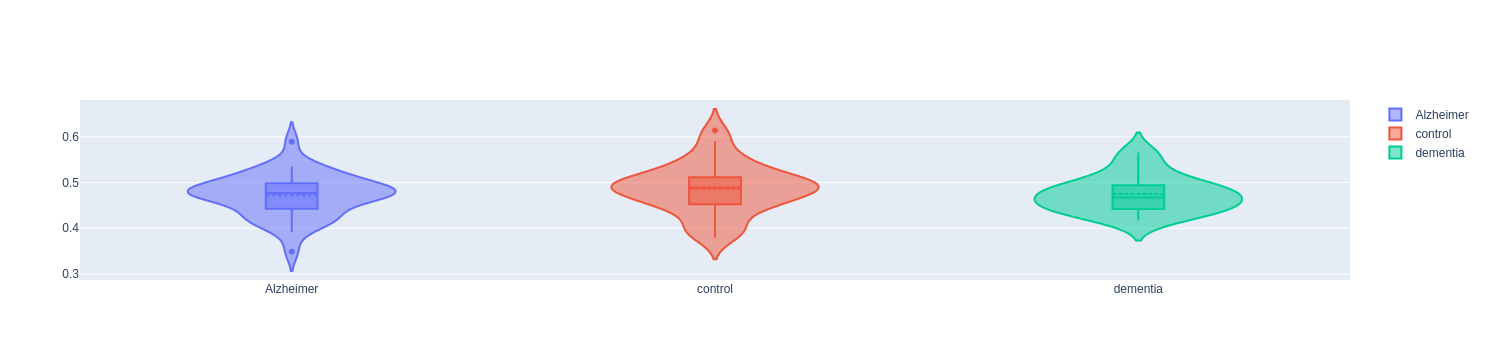

In [215]:
fig = go.Figure()
fig.add_trace(go.Violin(
    y=gfs_mean_alz, 
    name='Alzheimer',
    box_visible=True, 
    meanline_visible=True,
))
fig.add_trace(go.Violin(
    y=gfs_mean_con,
    name='control',
    box_visible=True, 
    meanline_visible=True,
))
fig.add_trace(go.Violin(
    y=gfs_mean_dem, 
    name='dementia',
    box_visible=True, 
    meanline_visible=True,
))
fig.show()

In [217]:
import scikit_posthocs as sp

from scipy.stats import kruskal, f_oneway, mannwhitneyu

print('#'*30)
print(f_oneway(gfs_mean_alz.to_numpy(), gfs_mean_con.to_numpy(), gfs_mean_dem.to_numpy()))
posthoc_x = [gfs_mean_alz.to_numpy(), gfs_mean_con.to_numpy(), gfs_mean_dem.to_numpy()]
posthoc_g = [['alz']*gfs_mean_alz.to_numpy().shape[0], ['con']*gfs_mean_con.to_numpy().shape[0], ['dem']*gfs_mean_dem.to_numpy().shape[0]]
print(sp.posthoc_tukey_hsd(np.concatenate(posthoc_x), np.concatenate(posthoc_g)))
print('#'*30)

print('#'*30)
print(kruskal(gfs_mean_alz.to_numpy(), gfs_mean_con.to_numpy(), gfs_mean_dem.to_numpy()))
print('Dunn test for Kruskal-Wallis')
print(sp.posthoc_dunn([gfs_mean_alz.to_numpy(), gfs_mean_con.to_numpy(), gfs_mean_dem.to_numpy()], )) #p_adjust='holm'
print('#'*30)

print(mannwhitneyu(gfs_mean_alz.to_numpy(), gfs_mean_con.to_numpy()))
print(mannwhitneyu(gfs_mean_con.to_numpy(), gfs_mean_dem.to_numpy()))

##############################
F_onewayResult(statistic=0.7861321044519405, pvalue=0.45888763406693645)
     alz  con  dem
alz    1    0    0
con    0    1    0
dem    0    0    1
##############################
##############################
KruskalResult(statistic=1.7425477761629509, pvalue=0.4184181916534053)
Dunn test for Kruskal-Wallis
          1         2         3
1  1.000000  0.242269  0.944935
2  0.242269  1.000000  0.266565
3  0.944935  0.266565  1.000000
##############################
MannwhitneyuResult(statistic=433.0, pvalue=0.24284057527113379)
MannwhitneyuResult(statistic=393.0, pvalue=0.27702327185596975)


## cross synchronization divergence plot

In [241]:
folder_name = '/media/hengjie/4TB/synchronization/'
file_name = 'cross_synch_freq6.5-8_mean1_std0.1_range1.5_bins30_wass_Fp1Fp2F3F4C3C4P3P4O1O2F7F8T3T4T5T6FzCzPz.tsv'
df_xsynch_data = pd.read_csv(f'{folder_name}/{file_name}', sep='\t')#, usecols=[1,2,3])

In [242]:
df_xsynch_data

,participant_id,cross_synch
0,sub-001,0.026860
1,sub-002,0.026616
2,sub-003,0.025579
3,sub-004,0.025710
4,sub-005,0.027536
...,...,...
83,sub-084,0.024889
84,sub-085,0.025076
85,sub-086,0.025029
86,sub-087,0.026253


In [243]:
alz_list = []
for f in tqdm(alz_eeg_file, position=0):
    split_part = f.split('/')
    temp_participant_id = split_part[-3]
    alz_list.append(temp_participant_id)
    
    
con_list = []
for f in tqdm(con_eeg_file, position=0): 
    split_part = f.split('/')
    temp_participant_id = split_part[-3]
    con_list.append(temp_participant_id)
    
    
dem_list = []
for f in tqdm((dem_eeg_file), position=0):
    split_part = f.split('/')
    temp_participant_id = split_part[-3]
    dem_list.append(temp_participant_id)
    

xsynch_alz = df_xsynch_data.loc[df_xsynch_data['participant_id'].isin(alz_list), 'cross_synch']
xsynch_con = df_xsynch_data.loc[df_xsynch_data['participant_id'].isin(con_list), 'cross_synch']
xsynch_dem = df_xsynch_data.loc[df_xsynch_data['participant_id'].isin(dem_list), 'cross_synch']

100%|███████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 145066.15it/s]


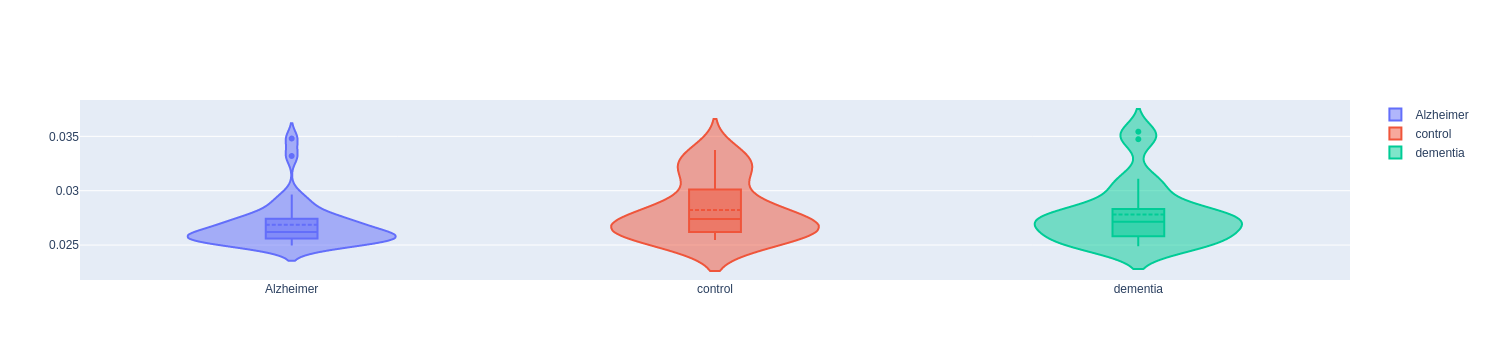

In [244]:
fig = go.Figure()
fig.add_trace(go.Violin(
    y=xsynch_alz, 
    name='Alzheimer',
    box_visible=True, 
    meanline_visible=True,
))
fig.add_trace(go.Violin(
    y=xsynch_con,
    name='control',
    box_visible=True, 
    meanline_visible=True,
))
fig.add_trace(go.Violin(
    y=xsynch_dem, 
    name='dementia',
    box_visible=True, 
    meanline_visible=True,
))
fig.show()

In [246]:
import scikit_posthocs as sp

from scipy.stats import kruskal, f_oneway, mannwhitneyu

print('#'*30)
print(f_oneway(xsynch_alz.to_numpy(), xsynch_con.to_numpy(), xsynch_dem.to_numpy()))
posthoc_x = [xsynch_alz.to_numpy(), xsynch_con.to_numpy(), xsynch_dem.to_numpy()]
posthoc_g = [['alz']*xsynch_alz.to_numpy().shape[0], ['con']*xsynch_con.to_numpy().shape[0], ['dem']*xsynch_dem.to_numpy().shape[0]]
print(sp.posthoc_tukey_hsd(np.concatenate(posthoc_x), np.concatenate(posthoc_g)))
print('#'*30)

print('#'*30)
print(kruskal(xsynch_alz.to_numpy(), xsynch_con.to_numpy(), xsynch_dem.to_numpy()))
print('Dunn test for Kruskal-Wallis')
print(sp.posthoc_dunn([xsynch_alz.to_numpy(), xsynch_con.to_numpy(), xsynch_dem.to_numpy()], p_adjust='holm'))
print('#'*30)

print(mannwhitneyu(xsynch_alz.to_numpy(), xsynch_con.to_numpy()))
print(mannwhitneyu(xsynch_con.to_numpy(), xsynch_dem.to_numpy()))

##############################
F_onewayResult(statistic=2.520730143854054, pvalue=0.0863966351310986)
     alz  con  dem
alz    1    0    0
con    0    1    0
dem    0    0    1
##############################
##############################
KruskalResult(statistic=6.241398644395872, pvalue=0.04412629912666795)
Dunn test for Kruskal-Wallis
          1         2         3
1  1.000000  0.042641  0.289461
2  0.042641  1.000000  0.425573
3  0.289461  0.425573  1.000000
##############################
MannwhitneyuResult(statistic=332.0, pvalue=0.012391583454133026)
MannwhitneyuResult(statistic=372.0, pvalue=0.48385147698367215)
check PMF of data: 	 1.0000000000000022
mean of data: 	 0.5684301741817475
std of data: 	 0.5633783561450915
check PMF of normal: 	 1.0000000000000016
check normal PMF mean: 	 1.0001500000000016
check normal PMF std: 	 0.10393256226996424
bin size of PMF: 30
check PMF of data: 	 1.0000000000000029
mean of data: 	 0.7272351605178956
std of data: 	 0.44380935570874147
che

# SVM classification
Should also try it with Random Forest classification too.